<img src='static/img/logo.gif' width=400>

# Хакатон. Задача от `B`e`e`l`i`n`e`

##### `Задача`: необходимо создать модель для бинарной классификации аудиофрагментов с целью определения качества их транскрибации.

___
# <center> <a style='color:gold'>Sbert fine-tuning</a>
___
### <a id=100 style='color:gold'>Содержание</a>

- [Предобработка данных](#555)
    - [Импорт данных](#1)
    - [Разделение на выборки](#2)
    - [Токенизация и создание датасета](#3)

- [Дообучение модели](#4)

- [Оценка качества и сохранение модели](#5)

- [Загрузка модели на Huggingface](#6)

- [Инференс модели](#7)

___
## <center> <a id=1 style='color:gold'>Импорт данных</a>

### Импорт библиотек

In [1]:
%matplotlib inline
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pytorch_lightning import seed_everything
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import  Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from huggingface_hub import notebook_login


seed_everything(42)
np.random.seed(42)

Seed set to 42


### Импорт обучающего датафрейма

In [2]:
FILE_PATH = 'data/hackaton_result_dataset.xlsx'

df_train = pd.read_excel(FILE_PATH)
df_train[:3]

,model_annotation,human_markup,audio_path,label
0,давай по россии значит на коленях быстро блять...,давай проси значит на коленях быстро блять,s3://ap-training-set/xacaton_openstt/part_1/05...,1
1,ну разве можно так с телефоном поступает,ну что ну разве можно так с телефоном поступать,s3://ap-training-set/xacaton_openstt/part_1/05...,0
2,у меня нет с собой в полном адресе я щас дома ...,у меня нет с собой полного адреса я щас из дом...,s3://ap-training-set/xacaton_openstt/part_1/05...,0


### Импорт тестового датафрейма

In [3]:
FILE_PATH = 'data/data_part1.xlsx'

df_test = pd.read_excel(FILE_PATH)
df_test[:3]

,annotation_fastconformer,human_markup,audio_path,label
0,у нас здесь муж много,вот у нас здесь мух много,51b0fadce17e.wav,0
1,понимаешь если бы это был случай он тебя не бо...,понимаешь если бы это было случайно он бы тебя...,42e052ce1540.wav,0
2,вот как ты языков своих трепишь блять они еще ...,вот как ты языком своим треплешь блять они ещё...,42de1bfba887.wav,0


___
## <center> <a id=2 style='color:gold'>Разделение на выборки</a>

### Валидационная и обучающая

In [4]:
X = df_train['model_annotation']
y = df_train['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

X_train = X_train.astype('str').reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.astype('str').reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5857,), (5857,), (651,), (651,))

### Тестовая выборка

In [5]:
X = df_test['annotation_fastconformer']
y = df_test['label']
X_test = X.astype('str').reset_index(drop=True)
y_test = y.reset_index(drop=True)

X_test.shape, y_test.shape

((10000,), (10000,))

___
## <center> <a id=3 style='color:gold'>Токенизация и создание датасета</a>

### Импорт токенайзера

In [ ]:
tokenizer = BertTokenizer.from_pretrained("ai-forever/sbert_large_mt_nlu_ru")

### Токенизация выборок

- max_length: максимальная длина последовательности
- pad_to_max_length: следует ли дополнять последовательности до максимальной длины
- truncation: следует ли усекать последовательности, превышающие максимальную длину

In [8]:
tokens_train = tokenizer.batch_encode_plus(X_train.values)
tokens_val = tokenizer.batch_encode_plus(X_val.values)
tokens_test = tokenizer.batch_encode_plus(X_test.values)

### Создание датасетов для модели

In [9]:
class Data(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
    
train_dataset = Data(tokens_train, y_train)
val_dataset = Data(tokens_val, y_val)
test_dataset = Data(tokens_test, y_test)

___
## <center> <a id=4 style='color:gold'>Дообучение модели</a>

### Импорт исходной модели


In [ ]:
model = BertForSequenceClassification.from_pretrained('ai-forever/sbert_large_mt_nlu_ru', num_labels=2).to("cuda")

### Загрузка обученной модели

In [10]:
model = BertForSequenceClassification.from_pretrained('data/models/ft_l15_80_sbert_large', num_labels=2).to("cuda")

- Отключение слоев

In [11]:
for param in model.bert.parameters():
    param.requires_grad = False

model.classifier

Linear(in_features=1024, out_features=2, bias=True)

- Включение слоев

In [13]:
for i in range(15, 24):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = True

model.bert.encoder.layer

ModuleList(
  (0-23): 24 x BertLayer(
    (attention): BertAttention(
      (self): BertSelfAttention(
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (output): BertSelfOutput(
        (dense): Linear(in_features=1024, out_features=1024, bias=True)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (intermediate): BertIntermediate(
      (dense): Linear(in_features=1024, out_features=4096, bias=True)
      (intermediate_act_fn): GELUActivation()
    )
    (output): BertOutput(
      (dense): Linear(in_features=4096, out_features=1024, bias=True)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )


### Вычисление метрик при обучении

In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    proba = torch.nn.functional.softmax(torch.FloatTensor(pred.predictions), dim=1)[:, 1]
    roc_auc = roc_auc_score(labels, proba)
    return {'roc_auc_score': roc_auc}

### Параметры обучения

- weight_decay: регуляризация
- evaluation_strategy: период оценки метрик обучения

In [15]:
training_args = TrainingArguments(
    output_dir = './data/results', 
    num_train_epochs = 2,
    per_device_train_batch_size = 8, 
    per_device_eval_batch_size = 8,
    weight_decay =0, 
    logging_dir = './data/logs', 
    load_best_model_at_end = True, 
    learning_rate = 1e-4, 
    evaluation_strategy ='epoch', 
    logging_strategy = 'epoch', 
    save_strategy = 'epoch', 
    save_total_limit = 1,
    seed=21)

### Обучение

In [16]:
trainer = Trainer(model=model,
                  tokenizer = tokenizer,
                  args = training_args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics = compute_metrics)

trainer.train()

___
## <center> <a id=5 style='color:gold'>Оценка качества и сохранение модели</a>


- Классификационный отчет
- ROC-AUC

  0%|          | 0/733 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      5876
           1       0.72      0.59      0.65      4124

    accuracy                           0.74     10000
   macro avg       0.73      0.71      0.72     10000
weighted avg       0.74      0.74      0.73     10000



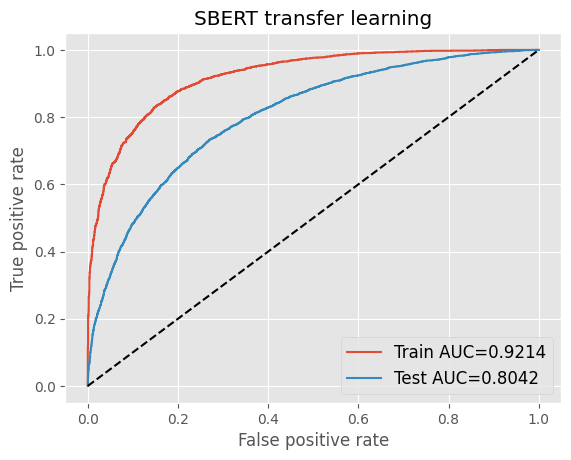

In [17]:
def model_evaluation(trainer: Trainer,
                    train_dataset: Dataset, 
                    test_dataset: Dataset, 
                    train_labels: pd.Series, 
                    test_labels: pd.Series) -> None:
    
    train_out = trainer.predict(train_dataset)
    test_out = trainer.predict(test_dataset)
    
    test_pred_labels = np.argmax(test_out.predictions, axis = -1)
    
    train_proba = torch.nn.functional.softmax(torch.FloatTensor(train_out.predictions), dim=1)[:, 1]
    test_proba = torch.nn.functional.softmax(torch.FloatTensor(test_out.predictions), dim=1)[:, 1]
    
    train_auc = roc_auc_score(train_labels, train_proba)
    test_auc = roc_auc_score(test_labels, test_proba)


    plt.style.use('ggplot');
    ax = plt.subplot()
    
    plt.plot(*roc_curve(train_labels, train_proba)[:2], label='%s AUC=%.4f' % ('Train', train_auc))
    plt.plot(*roc_curve(test_labels, test_proba)[:2], label='%s AUC=%.4f' % ('Test', test_auc))
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.plot([0, 1], [0, 1], '--', color='black',)
    ax.set_title('SBERT transfer learning')
    ax.legend(fontsize='large')

    print(classification_report(test_labels, test_pred_labels))

model_evaluation(trainer=trainer, train_dataset=train_dataset, test_dataset=test_dataset, train_labels=y_train, test_labels=y_test)

### Локальное сохранение обученной модели

In [ ]:
# model_path = "data/models/ft_sbert_large_some_result"

# model.save_pretrained(model_path)
# tokenizer.save_pretrained(model_path)

___
## <center> <a id=6 style='color:gold'>Загрузка модели на Huggingface</a>

[Документация ](https://huggingface.co/docs/transformers/model_sharing)

### Локальная загрузка обученной модели

In [ ]:
MODEL_PATH = 'data/models/ft_l15_80_sbert_large'

model = BertForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

### Вход в систему Huggingface

In [ ]:
notebook_login()

### Загрузка обученной модели на Huggingface

In [ ]:
HUG_PATH = "nazarovmichail/sbert_large_transcription_classification"

model.push_to_hub(HUG_PATH)
tokenizer.push_to_hub(HUG_PATH)

___
## <center> <a id=7 style='color:gold'>Инференс модели</a>

### Импорт тестового датасета

In [18]:
FILE_PATH = 'data/data_part1.xlsx'

df = pd.read_excel(FILE_PATH)
df[:2]

,annotation_fastconformer,human_markup,audio_path,label
0,у нас здесь муж много,вот у нас здесь мух много,51b0fadce17e.wav,0
1,понимаешь если бы это был случай он тебя не бо...,понимаешь если бы это было случайно он бы тебя...,42e052ce1540.wav,0


### Импорт обученной модели

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = BertForSequenceClassification.from_pretrained('nazarovmichail/sbert_large_transcription_classification').to(device)
tokenizer = BertTokenizer.from_pretrained('nazarovmichail/sbert_large_transcription_classification')

### Оценка качества транскрибации по предложению

In [20]:
def seq_prediction(sequence: str,
                    model=model,
                    tokenizer=tokenizer) -> None:
    """Функция оценивает качество транскрибации при помощи обученной модели

    Args:
        sequence (str): Текстовый фрагмент транскрибации
        model (_type_, optional): Обученная модель. Defaults to model.
        tokenizer (_type_, optional): Токенайзер. Defaults to tokenizer.
    """

    tokens = tokenizer(sequence, return_tensors="pt").to(device)
    
    with torch.no_grad():
        logits = model(**tokens).logits

    predicted_class = logits.argmax().item()
    if predicted_class:
        print(f'Аудиофрагмент транскрибирован некачественно')
    else:
        print(f'Аудиофрагмент транскрибирован качественно')


sequence = "грузинского информата"

seq_prediction(sequence)

Аудиофрагмент транскрибирован некачественно


### Оценка качества модели на датасете

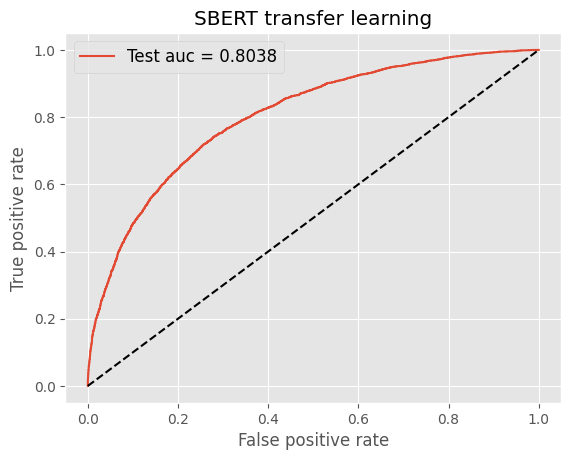

In [21]:
def model_evaluation(
                    test_inputs: list, 
                    test_labels: list,
                    model: BertForSequenceClassification=model,
                    tokenizer: BertTokenizer=tokenizer,
                    device: str=device,
                    batch_size=10,
                    verbose: bool=True) -> np.ndarray:
    """Функция для оценки обученной модели. Изображает ROC-кривую и рассчитывает показатель AUC.

    Args:
        test_inputs (list): Список тестовых транскрибированных предложений
        test_labels (list): Список тестовых лейблов 
        model (BertForSequenceClassification, optional): Обученная модель. Defaults to model.
        tokenizer (BertTokenizer, optional): Токенайзер. Defaults to tokenizer.
        device (str, optional): Устройство для вычислений (cuda / cpu). Defaults to device.
        batch_size (int, optional): Размер батчей. Defaults to 10.
        verbose (bool, optional): Отображение прогрессбара при оценке модели . Defaults to True.

    Returns:
        np.ndarray: Вероятности модели для 1 класса
    """
    
    tokens = tokenizer(test_inputs, padding=True, return_tensors='pt').to(device)
    SAMPLES_N = len(test_inputs)

    total_test_out = torch.zeros(batch_size)
    if verbose:
        for start_idx in trange(0, SAMPLES_N, batch_size):
            input_batch = tokens[start_idx: start_idx + batch_size]
            with torch.no_grad():
                test_out = model(**input_batch).logits[:,1]
                if start_idx == 0:
                    total_test_out = test_out
                else:
                    total_test_out = torch.cat((total_test_out, test_out))
    else:
        for start_idx in range(0, SAMPLES_N, batch_size):
            input_batch = tokens[start_idx: start_idx + batch_size]
            with torch.no_grad():
                test_out = model(**input_batch).logits[:,1]
                if start_idx == 0:
                    total_test_out = test_out
                else:
                    total_test_out = torch.cat((total_test_out, test_out))

    test_proba = torch.nn.functional.softmax(total_test_out, dim=0).detach().cpu().numpy()
    test_auc = roc_auc_score(test_labels, test_proba, )


    plt.style.use('ggplot');
    ax = plt.subplot()
    
    plt.plot(*roc_curve(test_labels, test_proba)[:2], label=f'Test auc = {test_auc:.4f}')
    
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.plot([0, 1], [0, 1], '--', color='black',)
    ax.set_title('SBERT transfer learning')
    ax.legend(fontsize='large')

    return test_proba


test_inputs = df['annotation_fastconformer'].tolist()
test_labels = df['label'].tolist()

test_proba = model_evaluation(test_inputs=test_inputs,
                            test_labels=test_labels, 
                            verbose=False)